In [154]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import pytz
import numpy as np
import os

In [155]:
#open CO2 files, extract relevant columns, normalize column names
co2_burned_2022 = pd.read_csv('Burned_Pond_CO2_062422-081622.csv')[['TIMESTAMP','CO2_High_ppm','CO2_High_RA_ppm','WaterTemp_degC']]
co2_burned_2022['pond'] = 'burned'
co2_burned_2022['co2_depth'] = 1.0
co2_burned_2022['temp_depth'] = 1.0

co2_burned_2023 = pd.read_excel('Dissolved_CO2_15BPond_070723-091123.xlsx')[['TIMESTAMP','CO2_High_ppm','CO2_High_RA_ppm','Water_Temp_degC']]
co2_burned_2023 = co2_burned_2023.rename(columns={'Water_Temp_degC':'WaterTemp_degC'})
co2_burned_2023['pond'] = 'burned'

co2_burned_2024 = pd.read_excel('Dissolved_CO2_15BPond_070724-090824.xlsx')[['TIMESTAMP','CO2_High','CO2_High_RA']]
co2_burned_2024 = co2_burned_2024.rename(columns={'CO2_High':'CO2_High_ppm', 'CO2_High_RA':'CO2_High_RA_ppm'})
co2_burned_2024['pond'] = 'burned'
co2_burned_2024['WaterTemp_degC'] = np.nan

co2_unburned_2022 = pd.read_csv('UB_Pond_CO2_062622-072822.csv')[['Date','CO2_High_ppm','CO2_High_RA_ppm','WaterTemp_degC']]
co2_unburned_2022['pond'] = 'unburned'
co2_unburned_2022 = co2_unburned_2022.rename(columns={'Date':'TIMESTAMP'})

co2_unburned_2023 = pd.read_excel('Dissolved_CO2_UBPond_070223-091123.xlsx')[['Timestamp','CO2_High_ppm','CO2_High_RA_ppm','Water_Temp_degC']]
co2_unburned_2023 = co2_unburned_2023.rename(columns={'Timestamp': 'TIMESTAMP', 'Water_Temp_degC':'WaterTemp_degC'})
co2_unburned_2023['pond'] = 'unburned'

co2_unburned_2024 = pd.read_excel('Dissolved_CO2_UBPond_071524-090824.xlsx')[['TIMESTAMP','CO2_High','CO2_High_RA']]
co2_unburned_2024 = co2_unburned_2024.rename(columns={'CO2_High':'CO2_High_ppm', 'CO2_High_RA':'CO2_High_RA_ppm'})
co2_unburned_2024['pond'] = 'unburned'
co2_unburned_2024['WaterTemp_degC'] = np.nan

#merge all co2 files
co2_all = pd.concat([co2_burned_2022, co2_burned_2023, co2_burned_2024, 
                     co2_unburned_2022, co2_unburned_2023, co2_unburned_2024])
co2_all['TIMESTAMP'] = pd.to_datetime(co2_all['TIMESTAMP'])

co2_all_daily = co2_all.groupby(by=['pond',co2_all['TIMESTAMP'].dt.date]).aggregate({
                                                                                      'CO2_High_ppm':['mean', 'std'],
                                                                                      'WaterTemp_degC':['mean', 'std']
                                                                                        })
co2_all_daily.columns = ["_".join(a) for a in co2_all_daily.columns.to_flat_index()]
co2_all_daily = co2_all_daily.reset_index()
co2_all_daily['co2_depth'] = 1.0
co2_all_daily['temp_depth'] = 1.0
co2_all_daily.head(5)

,pond,TIMESTAMP,CO2_High_ppm_mean,CO2_High_ppm_std,WaterTemp_degC_mean,WaterTemp_degC_std,co2_depth,temp_depth
0,burned,2022-06-24,1268.185481,641.426389,NaN,NaN,1.0,1.0
1,burned,2022-06-25,1183.261600,136.955860,NaN,NaN,1.0,1.0
2,burned,2022-06-26,874.438129,120.871066,NaN,NaN,1.0,1.0
3,burned,2022-06-27,841.687394,49.184830,NaN,NaN,1.0,1.0
4,burned,2022-06-28,999.626102,89.336912,NaN,NaN,1.0,1.0


In [156]:
#open 2024 temperature files
july_dir = '../temperature/Collected_202407'
sept_dir = '../temperature/Collected_202409'

In [157]:
files=[os.path.join(july_dir, f) for f in os.listdir(july_dir)]+[os.path.join(sept_dir, f) for f in os.listdir(sept_dir)]
temp_2024=[]
for file in files:
    
    df=pd.read_csv(file, parse_dates=['Date-Time (AKDT)'])
    df = df[['Date-Time (AKDT)', 'WaterTemp_degC']].rename(columns={'Date-Time (AKDT)': 'TIMESTAMP'})
    df['chamber'] = int(file.split(' ')[1])
    temp_2024.append(df)
temp_2024=pd.concat(temp_2024)

#AKDT to AKST
temp_2024['TIMESTAMP'] = temp_2024['TIMESTAMP'].dt.tz_localize(pytz.timezone('Etc/GMT+8'))
temp_2024['TIMESTAMP'] = temp_2024['TIMESTAMP'].dt.tz_convert(pytz.timezone('Etc/GMT+9'))
temp_2024['pond'] = 'unburned'
temp_2024.loc[temp_2024['chamber']<=3, 'pond'] = 'burned'

In [158]:
temp_2024_daily = temp_2024.groupby(by=['chamber',temp_2024['TIMESTAMP'].dt.date]).aggregate({
                                                                                      'WaterTemp_degC':['mean', 'std']
                                                                                        })
temp_2024_daily.columns = ["_".join(a) for a in temp_2024_daily.columns.to_flat_index()]
temp_2024_daily = temp_2024_daily.reset_index()
temp_2024_daily['pond'] = 'unburned'
temp_2024_daily.loc[temp_2024_daily['chamber']<=3, 'pond'] = 'burned'
temp_2024_daily.head()

,chamber,TIMESTAMP,WaterTemp_degC_mean,WaterTemp_degC_std,pond
0,1,2024-07-03,15.417785,0.848757,burned
1,1,2024-07-04,13.082141,0.497284,burned
2,1,2024-07-05,13.388893,0.843733,burned
3,1,2024-07-06,12.512972,0.409649,burned
4,1,2024-07-07,13.730064,2.154364,burned


<Axes: xlabel='TIMESTAMP', ylabel='WaterTemp_degC_mean'>

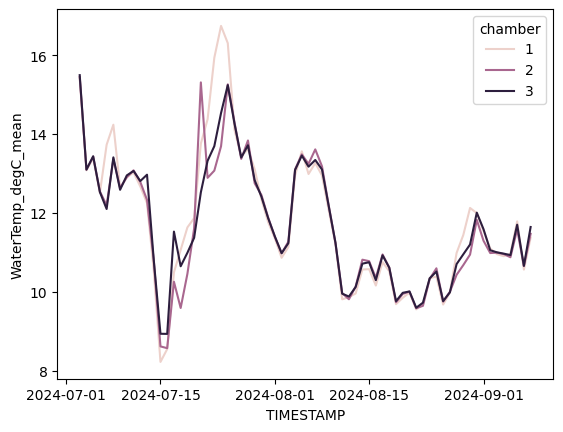

In [159]:
sns.lineplot(temp_2024_daily.loc[temp_2024_daily['pond']=='burned'],
             x='TIMESTAMP', y='WaterTemp_degC_mean', hue='chamber')


In [160]:
#daily mean and std temperature for burned and unburned ponds, 2024
temp_2024_daily_mean = temp_2024.groupby(by=['pond',temp_2024['TIMESTAMP'].dt.date]).aggregate({
                                                                                      'WaterTemp_degC':['mean', 'std']
                                                                                        })
temp_2024_daily_mean.columns = ["_".join(a) for a in temp_2024_daily_mean.columns.to_flat_index()]
temp_2024_daily_mean = temp_2024_daily_mean.reset_index()

temp_2024_daily_mean.head(5)

,pond,TIMESTAMP,WaterTemp_degC_mean,WaterTemp_degC_std
0,burned,2024-07-03,15.453616,0.830278
1,burned,2024-07-04,13.093383,0.500491
2,burned,2024-07-05,13.418579,0.856207
3,burned,2024-07-06,12.529478,0.407699
4,burned,2024-07-07,12.674640,1.466938


In [161]:
#merge 2024 temp data into rest of data
co2_all_daily = co2_all_daily.merge(temp_2024_daily_mean, 
                                    on=['pond', 'TIMESTAMP'], 
                                    how='left', suffixes=['', '_t2024'])

co2_all_daily['WaterTemp_degC_mean'] = co2_all_daily['WaterTemp_degC_mean'].combine_first(co2_all_daily['WaterTemp_degC_mean_t2024'])
co2_all_daily['WaterTemp_degC_std'] = co2_all_daily['WaterTemp_degC_std'].combine_first(co2_all_daily['WaterTemp_degC_std_t2024'])
co2_all_daily = co2_all_daily.drop(columns = ['WaterTemp_degC_mean_t2024', 'WaterTemp_degC_std_t2024'])

In [162]:
co2_all_daily

,pond,TIMESTAMP,CO2_High_ppm_mean,CO2_High_ppm_std,WaterTemp_degC_mean,WaterTemp_degC_std,co2_depth,temp_depth
0,burned,2022-06-24,1268.185481,641.426389,NaN,NaN,1.0,1.0
1,burned,2022-06-25,1183.261600,136.955860,NaN,NaN,1.0,1.0
2,burned,2022-06-26,874.438129,120.871066,NaN,NaN,1.0,1.0
3,burned,2022-06-27,841.687394,49.184830,NaN,NaN,1.0,1.0
4,burned,2022-06-28,999.626102,89.336912,NaN,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...
342,unburned,2024-09-04,15536.200833,363.629404,11.236898,0.305869,1.0,1.0
343,unburned,2024-09-05,15100.307917,535.196418,11.806944,0.643012,1.0,1.0
344,unburned,2024-09-06,15492.217500,588.666748,12.303171,0.480642,1.0,1.0
345,unburned,2024-09-07,15935.917083,480.660736,10.945486,0.368505,1.0,1.0


In [191]:
co2_all_daily = co2_all_daily.rename(columns={'TIMESTAMP': 'datetime', 
                                              'CO2_High_ppm_mean': 'CO2_meas_ppm_mean',
                                              'CO2_High_ppm_std': 'CO2_meas_ppm_std',  
                                              'WaterTemp_degC_mean': 'WaterTemp_meas_degC_mean',
                                              'WaterTemp_degC_std': 'WaterTemp_meas_degC_std'})

In [189]:
co2_all_daily.columns

Index(['pond', 'datetime', 'CO2_meas_ppm_mean', 'CO2_meas_ppm_std',
       'WaterTemp_degC_mean', 'WaterTemp_degC_std', 'co2_depth', 'temp_depth',
       'year'],
      dtype='object')

In [167]:
co2_all_daily['datetime'] = pd.to_datetime(co2_all_daily['datetime'])
co2_all_daily['year'] = co2_all_daily['datetime'].dt.year

In [199]:
co2_all_daily.to_csv('CO2_all.csv', index=False)

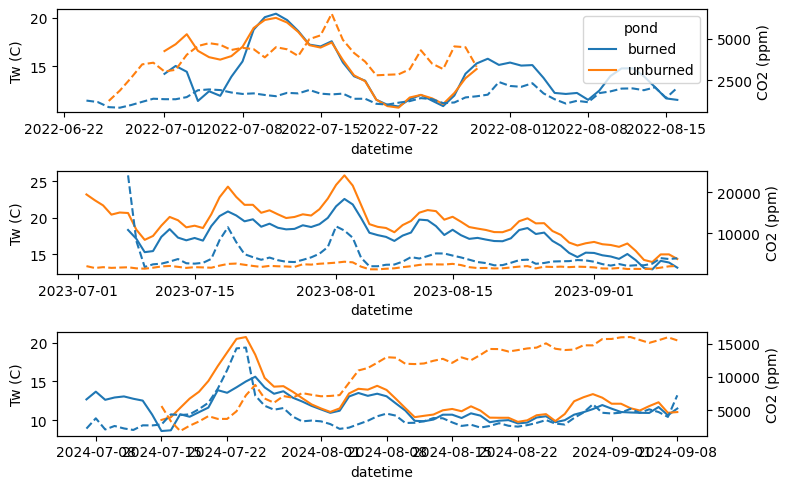

In [196]:
fig, axes = plt.subplots(len(co2_all_daily['year'].unique()),1, figsize=(8,5))
for i, year in enumerate(co2_all_daily['year'].unique()):
    data=co2_all_daily.loc[co2_all_daily['year']==year]
    sns.lineplot(data=data, x='datetime', y='WaterTemp_meas_degC_mean', ax=axes[i], hue='pond')
    ax_sec = axes[i].twinx()
    sns.lineplot(data=data, x='datetime', y='CO2_meas_ppm_mean', ax=ax_sec, hue='pond', linestyle='--')

    if i!=0:
        axes[i].get_legend().remove()
    ax_sec.get_legend().remove()
    axes[i].set_ylabel('Tw (C)')
    ax_sec.set_ylabel('CO2 (ppm)')

    
    #axes[i].set_xticklabels(axes[i].get_xticks(), rotation=30)
#fig.autofmt_xdate()
fig.tight_layout()

